# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 50, 50, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=50, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 50, 50, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 0.7811
Epoch 1/200, Iteration 2/12, Loss: 0.7544
Epoch 1/200, Iteration 3/12, Loss: 0.6078
Epoch 1/200, Iteration 4/12, Loss: 0.5100
Epoch 1/200, Iteration 5/12, Loss: 0.3796
Epoch 1/200, Iteration 6/12, Loss: 0.2482
Epoch 1/200, Iteration 7/12, Loss: 0.1457
Epoch 1/200, Iteration 8/12, Loss: 0.2252
Epoch 1/200, Iteration 9/12, Loss: 0.2141
Epoch 1/200, Iteration 10/12, Loss: 0.1595
Epoch 1/200, Iteration 11/12, Loss: 0.1291
Epoch 1/200, Iteration 12/12, Loss: 0.1889
Epoch 1/200, Iteration 13/12, Loss: 0.1349
Train Error: 
 Accuracy: 51.88%, Avg loss: 0.095308, MRE: 0.175044, MAE: 0.027220 

Test Error: 
 Accuracy: 61.0%, Avg loss: 0.071762, MRE: 0.162202, MAE: 0.023917 

Epoch 2/200, Iteration 1/12, Loss: 0.0733
Epoch 2/200, Iteration 2/12, Loss: 0.0915
Epoch 2/200, Iteration 3/12, Loss: 0.0524
Epoch 2/200, Iteration 4/12, Loss: 0.0577
Epoch 2/200, Iteration 5/12, Loss: 0.0755
Epoch 2/200, Iteration 6/12, Loss: 0.0596
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 98.88%, Avg loss: 0.003945, MRE: 0.030933, MAE: 0.004858 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.003891, MRE: 0.025203, MAE: 0.005103 

Epoch 13/200, Iteration 1/12, Loss: 0.0028
Epoch 13/200, Iteration 2/12, Loss: 0.0046
Epoch 13/200, Iteration 3/12, Loss: 0.0041
Epoch 13/200, Iteration 4/12, Loss: 0.0030
Epoch 13/200, Iteration 5/12, Loss: 0.0036
Epoch 13/200, Iteration 6/12, Loss: 0.0046
Epoch 13/200, Iteration 7/12, Loss: 0.0032
Epoch 13/200, Iteration 8/12, Loss: 0.0027
Epoch 13/200, Iteration 9/12, Loss: 0.0087
Epoch 13/200, Iteration 10/12, Loss: 0.0027
Epoch 13/200, Iteration 11/12, Loss: 0.0041
Epoch 13/200, Iteration 12/12, Loss: 0.0219
Epoch 13/200, Iteration 13/12, Loss: 0.0046
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.003864, MRE: 0.028496, MAE: 0.004482 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.004206, MRE: 0.024958, MAE: 0.004777 

Epoch 14/200, Iteration 1/12, Loss: 0.0023
Epoch 14/200, Iteration 2/12, Loss: 0.0023
Epoch 14/200, Itera

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001934, MRE: 0.019215, MAE: 0.003706 

Epoch 25/200, Iteration 1/12, Loss: 0.0018
Epoch 25/200, Iteration 2/12, Loss: 0.0009
Epoch 25/200, Iteration 3/12, Loss: 0.0021
Epoch 25/200, Iteration 4/12, Loss: 0.0027
Epoch 25/200, Iteration 5/12, Loss: 0.0022
Epoch 25/200, Iteration 6/12, Loss: 0.0017
Epoch 25/200, Iteration 7/12, Loss: 0.0018
Epoch 25/200, Iteration 8/12, Loss: 0.0012
Epoch 25/200, Iteration 9/12, Loss: 0.0014
Epoch 25/200, Iteration 10/12, Loss: 0.0024
Epoch 25/200, Iteration 11/12, Loss: 0.0009
Epoch 25/200, Iteration 12/12, Loss: 0.0042
Epoch 25/200, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.002048, MRE: 0.027274, MAE: 0.004271 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001929, MRE: 0.021773, MAE: 0.004291 

Epoch 26/200, Iteration 1/12, Loss: 0.0020
Epoch 26/200, Iteration 2/12, Loss: 0.0020
Epoch 26/200, Iteration 3/12, Loss: 0.0013
Epoch 26/200, Iteration 4/12, Loss: 0.0021
Epoch 26/200, Ite

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000598, MRE: 0.011000, MAE: 0.002190 

Epoch 37/200, Iteration 1/12, Loss: 0.0007
Epoch 37/200, Iteration 2/12, Loss: 0.0011
Epoch 37/200, Iteration 3/12, Loss: 0.0005
Epoch 37/200, Iteration 4/12, Loss: 0.0004
Epoch 37/200, Iteration 5/12, Loss: 0.0005
Epoch 37/200, Iteration 6/12, Loss: 0.0010
Epoch 37/200, Iteration 7/12, Loss: 0.0010
Epoch 37/200, Iteration 8/12, Loss: 0.0005
Epoch 37/200, Iteration 9/12, Loss: 0.0005
Epoch 37/200, Iteration 10/12, Loss: 0.0004
Epoch 37/200, Iteration 11/12, Loss: 0.0006
Epoch 37/200, Iteration 12/12, Loss: 0.0004
Epoch 37/200, Iteration 13/12, Loss: 0.0006
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.000509, MRE: 0.012739, MAE: 0.001869 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000437, MRE: 0.010656, MAE: 0.001803 

Epoch 38/200, Iteration 1/12, Loss: 0.0004
Epoch 38/200, Iteration 2/12, Loss: 0.0005
Epoch 38/200, Iteration 3/12, Loss: 0.0005
Epoch 38/200, Iteration 4/12, Loss: 0.0004
Epoch 38/200, Ite

Epoch 49/200, Iteration 6/12, Loss: 0.0005
Epoch 49/200, Iteration 7/12, Loss: 0.0005
Epoch 49/200, Iteration 8/12, Loss: 0.0003
Epoch 49/200, Iteration 9/12, Loss: 0.0002
Epoch 49/200, Iteration 10/12, Loss: 0.0006
Epoch 49/200, Iteration 11/12, Loss: 0.0003
Epoch 49/200, Iteration 12/12, Loss: 0.0004
Epoch 49/200, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000455, MRE: 0.012288, MAE: 0.002093 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000443, MRE: 0.010727, MAE: 0.002110 

Epoch 50/200, Iteration 1/12, Loss: 0.0005
Epoch 50/200, Iteration 2/12, Loss: 0.0004
Epoch 50/200, Iteration 3/12, Loss: 0.0003
Epoch 50/200, Iteration 4/12, Loss: 0.0011
Epoch 50/200, Iteration 5/12, Loss: 0.0006
Epoch 50/200, Iteration 6/12, Loss: 0.0005
Epoch 50/200, Iteration 7/12, Loss: 0.0012
Epoch 50/200, Iteration 8/12, Loss: 0.0003
Epoch 50/200, Iteration 9/12, Loss: 0.0007
Epoch 50/200, Iteration 10/12, Loss: 0.0005
Epoch 50/200, Iteration 11/12, Loss: 0.0004
Epoch 50/20

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000450, MRE: 0.014486, MAE: 0.001919 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000371, MRE: 0.009939, MAE: 0.001686 

Epoch 61/200, Iteration 1/12, Loss: 0.0004
Epoch 61/200, Iteration 2/12, Loss: 0.0002
Epoch 61/200, Iteration 3/12, Loss: 0.0004
Epoch 61/200, Iteration 4/12, Loss: 0.0004
Epoch 61/200, Iteration 5/12, Loss: 0.0002
Epoch 61/200, Iteration 6/12, Loss: 0.0003
Epoch 61/200, Iteration 7/12, Loss: 0.0003
Epoch 61/200, Iteration 8/12, Loss: 0.0002
Epoch 61/200, Iteration 9/12, Loss: 0.0003
Epoch 61/200, Iteration 10/12, Loss: 0.0003
Epoch 61/200, Iteration 11/12, Loss: 0.0002
Epoch 61/200, Iteration 12/12, Loss: 0.0001
Epoch 61/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000271, MRE: 0.010010, MAE: 0.001599 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000280, MRE: 0.007694, MAE: 0.001605 

Epoch 62/200, Iteration 1/12, Loss: 0.0002
Epoch 62/200, Iteration 2/12, Loss: 0.0003
Epoch 62/200, Iter

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000208, MRE: 0.010063, MAE: 0.001514 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000228, MRE: 0.007943, MAE: 0.001580 

Epoch 73/200, Iteration 1/12, Loss: 0.0002
Epoch 73/200, Iteration 2/12, Loss: 0.0002
Epoch 73/200, Iteration 3/12, Loss: 0.0002
Epoch 73/200, Iteration 4/12, Loss: 0.0002
Epoch 73/200, Iteration 5/12, Loss: 0.0002
Epoch 73/200, Iteration 6/12, Loss: 0.0002
Epoch 73/200, Iteration 7/12, Loss: 0.0002
Epoch 73/200, Iteration 8/12, Loss: 0.0001
Epoch 73/200, Iteration 9/12, Loss: 0.0004
Epoch 73/200, Iteration 10/12, Loss: 0.0002
Epoch 73/200, Iteration 11/12, Loss: 0.0003
Epoch 73/200, Iteration 12/12, Loss: 0.0001
Epoch 73/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000357, MRE: 0.009727, MAE: 0.001618 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000275, MRE: 0.008006, MAE: 0.001497 

Epoch 74/200, Iteration 1/12, Loss: 0.0005
Epoch 74/200, Iteration 2/12, Loss: 0.0002
Epoch 74/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000108, MRE: 0.007505, MAE: 0.000993 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000122, MRE: 0.006349, MAE: 0.001068 

Epoch 85/200, Iteration 1/12, Loss: 0.0001
Epoch 85/200, Iteration 2/12, Loss: 0.0001
Epoch 85/200, Iteration 3/12, Loss: 0.0002
Epoch 85/200, Iteration 4/12, Loss: 0.0001
Epoch 85/200, Iteration 5/12, Loss: 0.0001
Epoch 85/200, Iteration 6/12, Loss: 0.0001
Epoch 85/200, Iteration 7/12, Loss: 0.0001
Epoch 85/200, Iteration 8/12, Loss: 0.0002
Epoch 85/200, Iteration 9/12, Loss: 0.0001
Epoch 85/200, Iteration 10/12, Loss: 0.0001
Epoch 85/200, Iteration 11/12, Loss: 0.0002
Epoch 85/200, Iteration 12/12, Loss: 0.0002
Epoch 85/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000201, MRE: 0.009238, MAE: 0.001551 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000206, MRE: 0.007630, MAE: 0.001609 

Epoch 86/200, Iteration 1/12, Loss: 0.0002
Epoch 86/200, Iteration 2/12, Loss: 0.0001
Epoch 86/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000147, MRE: 0.007915, MAE: 0.001185 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000164, MRE: 0.007350, MAE: 0.001162 

Epoch 97/200, Iteration 1/12, Loss: 0.0002
Epoch 97/200, Iteration 2/12, Loss: 0.0002
Epoch 97/200, Iteration 3/12, Loss: 0.0002
Epoch 97/200, Iteration 4/12, Loss: 0.0001
Epoch 97/200, Iteration 5/12, Loss: 0.0001
Epoch 97/200, Iteration 6/12, Loss: 0.0001
Epoch 97/200, Iteration 7/12, Loss: 0.0002
Epoch 97/200, Iteration 8/12, Loss: 0.0001
Epoch 97/200, Iteration 9/12, Loss: 0.0002
Epoch 97/200, Iteration 10/12, Loss: 0.0001
Epoch 97/200, Iteration 11/12, Loss: 0.0001
Epoch 97/200, Iteration 12/12, Loss: 0.0001
Epoch 97/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000140, MRE: 0.007414, MAE: 0.001306 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000143, MRE: 0.005860, MAE: 0.001273 

Epoch 98/200, Iteration 1/12, Loss: 0.0001
Epoch 98/200, Iteration 2/12, Loss: 0.0002
Epoch 98/200, Ite

Epoch 108/200, Iteration 12/12, Loss: 0.0000
Epoch 108/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000043, MRE: 0.005121, MAE: 0.000618 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000055, MRE: 0.003276, MAE: 0.000634 

Epoch 109/200, Iteration 1/12, Loss: 0.0000
Epoch 109/200, Iteration 2/12, Loss: 0.0000
Epoch 109/200, Iteration 3/12, Loss: 0.0000
Epoch 109/200, Iteration 4/12, Loss: 0.0001
Epoch 109/200, Iteration 5/12, Loss: 0.0000
Epoch 109/200, Iteration 6/12, Loss: 0.0000
Epoch 109/200, Iteration 7/12, Loss: 0.0000
Epoch 109/200, Iteration 8/12, Loss: 0.0000
Epoch 109/200, Iteration 9/12, Loss: 0.0001
Epoch 109/200, Iteration 10/12, Loss: 0.0000
Epoch 109/200, Iteration 11/12, Loss: 0.0000
Epoch 109/200, Iteration 12/12, Loss: 0.0000
Epoch 109/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000038, MRE: 0.005040, MAE: 0.000601 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000050, MRE: 0.003271, MAE: 0.000626 



Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000048, MRE: 0.003034, MAE: 0.000597 

Epoch 120/200, Iteration 1/12, Loss: 0.0000
Epoch 120/200, Iteration 2/12, Loss: 0.0000
Epoch 120/200, Iteration 3/12, Loss: 0.0000
Epoch 120/200, Iteration 4/12, Loss: 0.0000
Epoch 120/200, Iteration 5/12, Loss: 0.0000
Epoch 120/200, Iteration 6/12, Loss: 0.0000
Epoch 120/200, Iteration 7/12, Loss: 0.0000
Epoch 120/200, Iteration 8/12, Loss: 0.0001
Epoch 120/200, Iteration 9/12, Loss: 0.0000
Epoch 120/200, Iteration 10/12, Loss: 0.0000
Epoch 120/200, Iteration 11/12, Loss: 0.0000
Epoch 120/200, Iteration 12/12, Loss: 0.0000
Epoch 120/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000036, MRE: 0.004866, MAE: 0.000579 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000049, MRE: 0.003348, MAE: 0.000618 

Epoch 121/200, Iteration 1/12, Loss: 0.0000
Epoch 121/200, Iteration 2/12, Loss: 0.0000
Epoch 121/200, Iteration 3/12, Loss: 0.0001
Epoch 121/200, Iteration 4/12, Loss: 0.000

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000046, MRE: 0.002933, MAE: 0.000592 

Epoch 132/200, Iteration 1/12, Loss: 0.0000
Epoch 132/200, Iteration 2/12, Loss: 0.0000
Epoch 132/200, Iteration 3/12, Loss: 0.0001
Epoch 132/200, Iteration 4/12, Loss: 0.0000
Epoch 132/200, Iteration 5/12, Loss: 0.0000
Epoch 132/200, Iteration 6/12, Loss: 0.0000
Epoch 132/200, Iteration 7/12, Loss: 0.0000
Epoch 132/200, Iteration 8/12, Loss: 0.0000
Epoch 132/200, Iteration 9/12, Loss: 0.0000
Epoch 132/200, Iteration 10/12, Loss: 0.0000
Epoch 132/200, Iteration 11/12, Loss: 0.0000
Epoch 132/200, Iteration 12/12, Loss: 0.0001
Epoch 132/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000035, MRE: 0.004769, MAE: 0.000570 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000046, MRE: 0.003006, MAE: 0.000599 

Epoch 133/200, Iteration 1/12, Loss: 0.0000
Epoch 133/200, Iteration 2/12, Loss: 0.0000
Epoch 133/200, Iteration 3/12, Loss: 0.0000
Epoch 133/200, Iteration 4/12, Loss: 0.000

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000045, MRE: 0.002955, MAE: 0.000601 

Epoch 144/200, Iteration 1/12, Loss: 0.0000
Epoch 144/200, Iteration 2/12, Loss: 0.0000
Epoch 144/200, Iteration 3/12, Loss: 0.0000
Epoch 144/200, Iteration 4/12, Loss: 0.0000
Epoch 144/200, Iteration 5/12, Loss: 0.0000
Epoch 144/200, Iteration 6/12, Loss: 0.0000
Epoch 144/200, Iteration 7/12, Loss: 0.0000
Epoch 144/200, Iteration 8/12, Loss: 0.0001
Epoch 144/200, Iteration 9/12, Loss: 0.0000
Epoch 144/200, Iteration 10/12, Loss: 0.0000
Epoch 144/200, Iteration 11/12, Loss: 0.0000
Epoch 144/200, Iteration 12/12, Loss: 0.0000
Epoch 144/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000035, MRE: 0.004829, MAE: 0.000585 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000047, MRE: 0.003062, MAE: 0.000591 

Epoch 145/200, Iteration 1/12, Loss: 0.0000
Epoch 145/200, Iteration 2/12, Loss: 0.0000
Epoch 145/200, Iteration 3/12, Loss: 0.0001
Epoch 145/200, Iteration 4/12, Loss: 0.000

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000032, MRE: 0.004667, MAE: 0.000559 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000042, MRE: 0.002908, MAE: 0.000580 

Epoch 156/200, Iteration 1/12, Loss: 0.0001
Epoch 156/200, Iteration 2/12, Loss: 0.0000
Epoch 156/200, Iteration 3/12, Loss: 0.0000
Epoch 156/200, Iteration 4/12, Loss: 0.0000
Epoch 156/200, Iteration 5/12, Loss: 0.0000
Epoch 156/200, Iteration 6/12, Loss: 0.0001
Epoch 156/200, Iteration 7/12, Loss: 0.0000
Epoch 156/200, Iteration 8/12, Loss: 0.0000
Epoch 156/200, Iteration 9/12, Loss: 0.0000
Epoch 156/200, Iteration 10/12, Loss: 0.0000
Epoch 156/200, Iteration 11/12, Loss: 0.0000
Epoch 156/200, Iteration 12/12, Loss: 0.0000
Epoch 156/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000038, MRE: 0.004773, MAE: 0.000602 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000046, MRE: 0.003197, MAE: 0.000639 

Epoch 157/200, Iteration 1/12, Loss: 0.0000
Epoch 157/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000036, MRE: 0.004816, MAE: 0.000579 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000043, MRE: 0.002863, MAE: 0.000594 

Epoch 168/200, Iteration 1/12, Loss: 0.0000
Epoch 168/200, Iteration 2/12, Loss: 0.0001
Epoch 168/200, Iteration 3/12, Loss: 0.0001
Epoch 168/200, Iteration 4/12, Loss: 0.0000
Epoch 168/200, Iteration 5/12, Loss: 0.0000
Epoch 168/200, Iteration 6/12, Loss: 0.0000
Epoch 168/200, Iteration 7/12, Loss: 0.0000
Epoch 168/200, Iteration 8/12, Loss: 0.0001
Epoch 168/200, Iteration 9/12, Loss: 0.0000
Epoch 168/200, Iteration 10/12, Loss: 0.0001
Epoch 168/200, Iteration 11/12, Loss: 0.0000
Epoch 168/200, Iteration 12/12, Loss: 0.0000
Epoch 168/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000039, MRE: 0.004753, MAE: 0.000593 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000044, MRE: 0.003009, MAE: 0.000618 

Epoch 169/200, Iteration 1/12, Loss: 0.0000
Epoch 169/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000037, MRE: 0.004773, MAE: 0.000588 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000047, MRE: 0.003148, MAE: 0.000597 

Epoch 180/200, Iteration 1/12, Loss: 0.0000
Epoch 180/200, Iteration 2/12, Loss: 0.0000
Epoch 180/200, Iteration 3/12, Loss: 0.0001
Epoch 180/200, Iteration 4/12, Loss: 0.0000
Epoch 180/200, Iteration 5/12, Loss: 0.0000
Epoch 180/200, Iteration 6/12, Loss: 0.0000
Epoch 180/200, Iteration 7/12, Loss: 0.0000
Epoch 180/200, Iteration 8/12, Loss: 0.0000
Epoch 180/200, Iteration 9/12, Loss: 0.0000
Epoch 180/200, Iteration 10/12, Loss: 0.0000
Epoch 180/200, Iteration 11/12, Loss: 0.0000
Epoch 180/200, Iteration 12/12, Loss: 0.0000
Epoch 180/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000034, MRE: 0.004780, MAE: 0.000575 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000043, MRE: 0.003043, MAE: 0.000603 

Epoch 181/200, Iteration 1/12, Loss: 0.0000
Epoch 181/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000031, MRE: 0.004712, MAE: 0.000540 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000039, MRE: 0.002761, MAE: 0.000546 

Epoch 192/200, Iteration 1/12, Loss: 0.0000
Epoch 192/200, Iteration 2/12, Loss: 0.0000
Epoch 192/200, Iteration 3/12, Loss: 0.0000
Epoch 192/200, Iteration 4/12, Loss: 0.0000
Epoch 192/200, Iteration 5/12, Loss: 0.0000
Epoch 192/200, Iteration 6/12, Loss: 0.0000
Epoch 192/200, Iteration 7/12, Loss: 0.0000
Epoch 192/200, Iteration 8/12, Loss: 0.0000
Epoch 192/200, Iteration 9/12, Loss: 0.0000
Epoch 192/200, Iteration 10/12, Loss: 0.0001
Epoch 192/200, Iteration 11/12, Loss: 0.0000
Epoch 192/200, Iteration 12/12, Loss: 0.0000
Epoch 192/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000031, MRE: 0.004614, MAE: 0.000552 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000040, MRE: 0.002931, MAE: 0.000563 

Epoch 193/200, Iteration 1/12, Loss: 0.0000
Epoch 193/200, Iteration 2/12, Loss: 0.0000
Ep

#### Plots loss vs Epoch

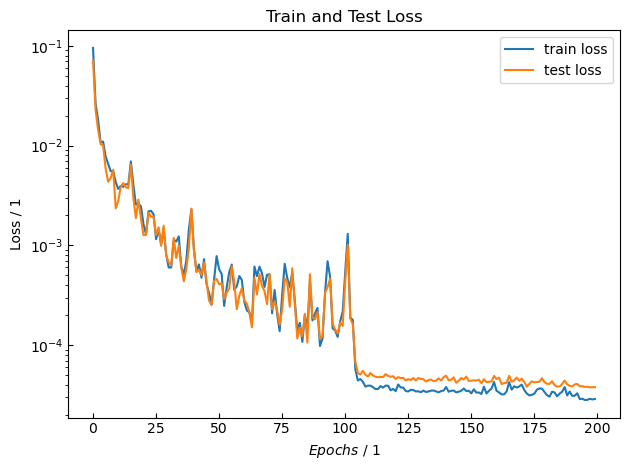

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999728684629945 , R^2(NH3) = 0.9999690575349286
Test Dataset: R^2(H2) = 0.9999542669405534 , R^2(NH3) = 0.9999620947546647
Max Error Training: |x_H2 - x_H2,pred| = 0.007804807895077703 , |x_NH3 - x_NH3,pred| = 0.003486400355600605
Max Error Test: |x_H2 - x_H2,pred| = 0.008590843374719714 , |x_NH3 - x_NH3,pred| = 0.004815112327745036


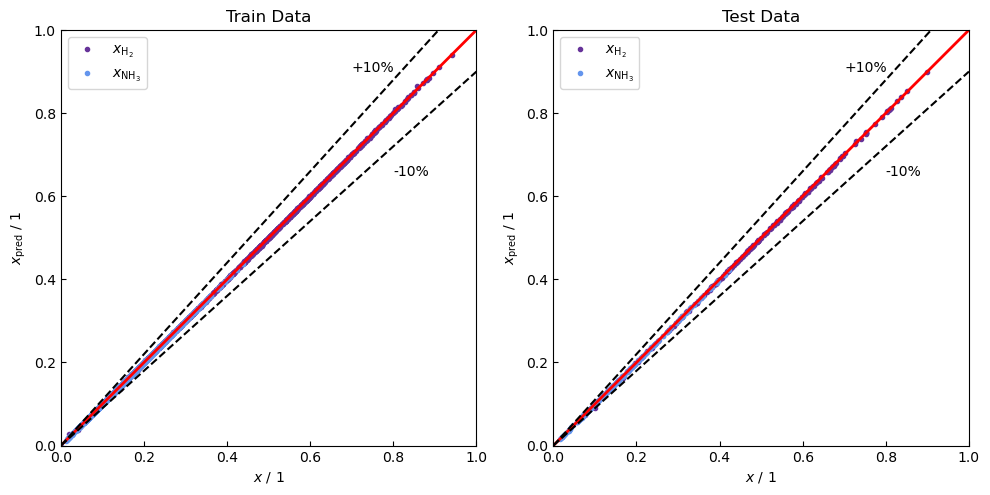

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

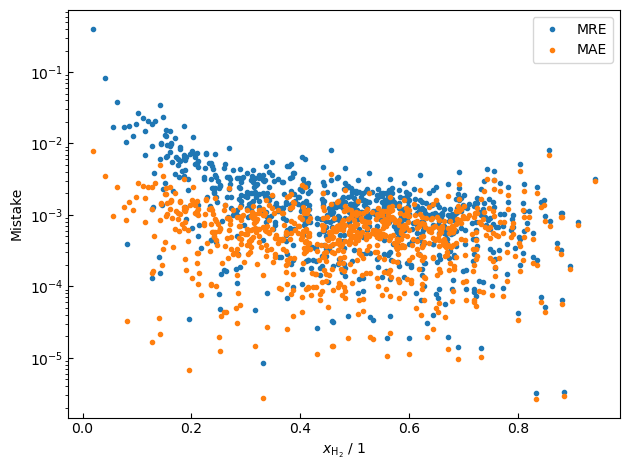

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

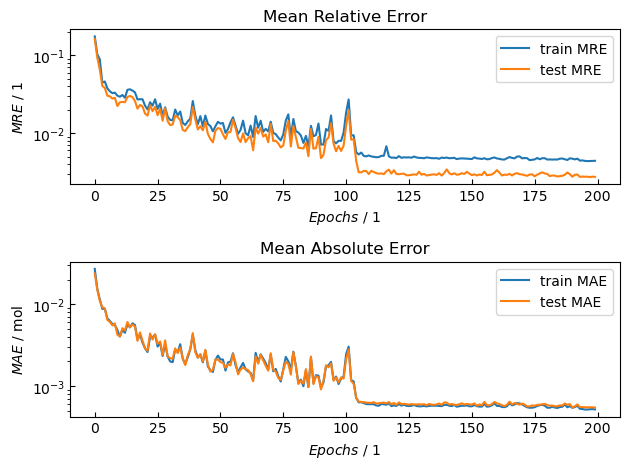

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

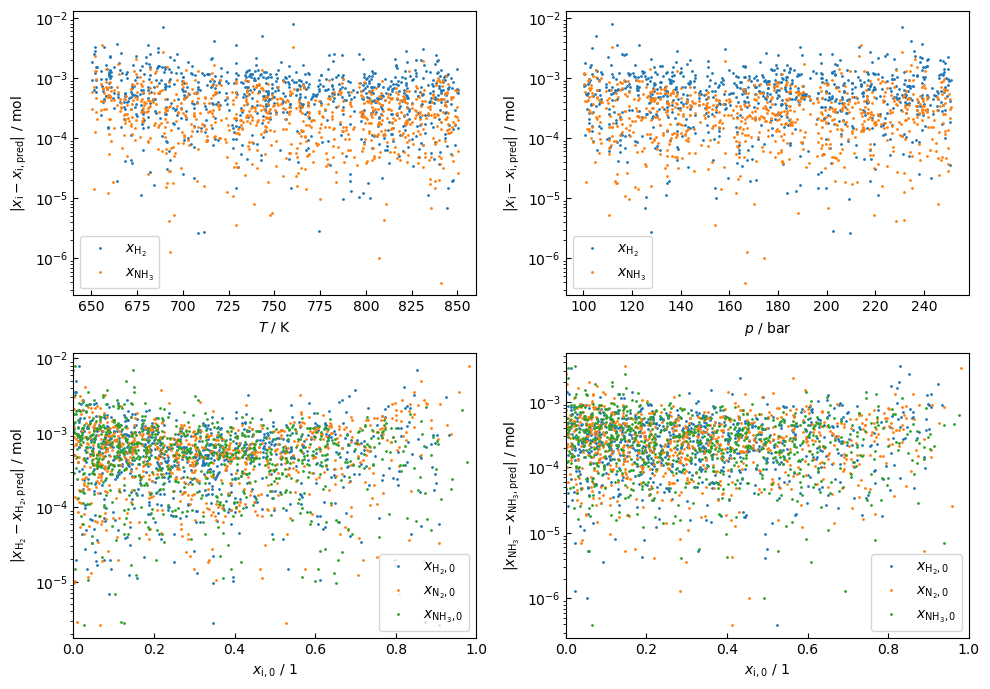

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

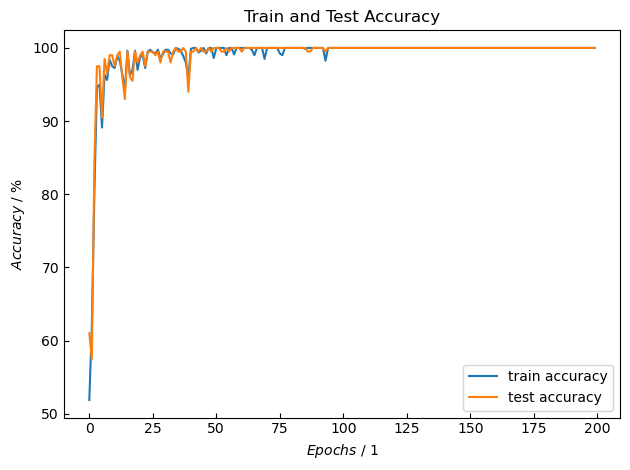

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.0 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-5.9056e-01, -1.1820e+00,  5.6155e-01, -7.2274e-02, -4.7722e-01],
        [ 1.2922e+00,  8.3739e-01,  1.2058e+00, -1.1108e+00, -4.8098e-02],
        [ 3.2869e-01, -7.6064e-02, -1.0797e+00, -1.1995e-01,  1.1822e+00],
        [ 7.6599e-03,  1.1344e-01, -9.7112e-01, -1.3698e+00,  2.3531e+00],
        [-7.4091e-01, -5.6096e-01, -1.2218e+00,  2.0842e+00, -9.3118e-01],
        [-1.1078e+00, -8.5609e-01, -1.0311e+00, -6.2151e-01,  1.6471e+00],
        [ 9.4894e-01,  1.6077e+00, -9.1511e-01, -2.1242e-01,  1.1152e+00],
        [-6.8468e-02, -1.0068e+00, -8.0976e-01, -5.4473e-01,  1.3514e+00],
        [ 7.5464e-01, -1.0573e+00,  3.6442e-03, -9.3567e-01,  9.5275e-01],
        [-1.6265e+00,  9.3778e-01, -9.3810e-01, -9.1788e-01,  1.8588e+00],
        [-1.3107e-01,  7.0073e-01, -1.2777e-02, -8.5380e-01,  8.8519e-01],
        [-1.0254e+00,  1.4990e+00,  1.3003e+00,  5.4971e-02, -1.3323e+00],
        [-1.5917e+00,  8.4825e-01,  4.9244e-01,  2.6210e-01, -7.5116e-01],
        [ 1.0957e+00, -2.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.3664, -0.2975, -0.1682,  0.3121, -0.0277],
         [-0.3519,  0.2128,  0.3219, -0.6011,  0.1571],
         [-0.0100,  0.3054,  0.1344,  0.4665,  0.0215],
         [ 0.1271, -0.0544, -0.0638,  0.4157, -0.3068],
         [ 0.1628,  0.2147,  0.2936, -0.2699,  0.2408],
         [-0.2520,  0.3959, -0.1006,  0.2739,  0.1125],
         [ 0.0397,  0.2158,  0.4618,  0.2578,  0.3323],
         [-0.1815,  0.3815, -0.3476, -0.3094, -0.0885],
         [-0.0419, -0.1707,  0.0481, -0.4288, -0.2719],
         [-0.2051, -0.1064,  0.2879, -0.2853, -0.1906],
         [ 0.0588,  0.1043,  0.1917,  0.0270, -0.4860],
         [ 0.1007, -0.4974,  0.1533,  0.4377,  0.2692],
         [ 0.2252, -0.0951, -0.0249,  0.3797,  0.1901],
         [ 0.2205,  0.1363,  0.3037, -0.0960,  0.1231],
         [-0.3654,  0.1922,  0.1003,  0.2323,  0.2939],
         [-0.2781,  0.1318, -0.1079,  0.3585, -0.4435],
         [-0.0171,  0.0729,  0.0987,  0.4911, -0.0938],
         [-0.6939,  0.158

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.2063, 0.8808, 0.1290, 0.6704, 0.8407],
        [0.0718, 0.8837, 0.9647, 0.2115, 0.6440]])
tensor([[-0.1814,  0.0985],
        [ 0.2967,  0.4906]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 9.7208e-01,  1.7176e+00,  1.4535e+00, -1.1569e+00, -2.4407e-01],
        [ 8.8372e-01,  1.0953e+00,  4.3870e-02, -1.2372e+00,  1.2215e+00],
        [-1.6128e+00, -1.0403e-01,  1.0120e+00, -1.6146e-01, -8.2811e-01],
        [-2.2407e-01,  3.0032e-01, -6.5543e-01,  1.7655e+00, -1.1613e+00],
        [-5.7496e-03, -1.6758e+00, -8.2352e-01, -1.0445e+00,  1.8757e+00],
        [-1.1962e+00, -8.3700e-01, -9.2801e-01, -9.0889e-01,  1.8397e+00],
        [ 1.4650e-01, -1.1116e+00, -7.3421e-01,  3.9395e-01,  3.1789e-01],
        [-1.2533e+00, -7.4784e-01,  1.8626e+00, -1.1219e+00, -6.8121e-01],
        [ 1.3474e+00,  1.6291e+00, -3.3033e-01, -1.1168e+00,  1.4656e+00],
        [-6.3971e-01,  1.1531e+00,  5.8135e-01,  4.7442e-03, -5.7538e-01],
        [-9.3041e-01,  3.3020e-01, -9.4471e-02, -1.1162e+00,  1.2335e+00],
        [-1.4236e+00, -5.0433e-01, -3.5978e-01,  8.0920e-01, -4.7398e-01],
        [-1.2146e-02, -9.3620e-01, -4.4086e-01,  1.5594e+00, -1.1612e+00],
        [-3.2462e-01,  6.

#### Histogramme Verteilung von $xi$ und $x{_i}$

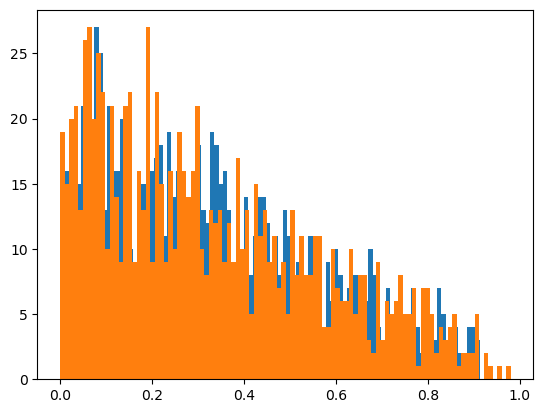

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_030.pth')
# np.savez('data/models/params_005_030.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)